# Dataset creation to train a YoloV8 model for tank detection

This notebook shows how to build a dataset of annotated images to train a computer vision model for object detection. We use images from open source object-detection datasets to create a dataset of military vehicles and format it correctly for YoloV8 training.

We use [fiftyone](https://github.com/voxel51/fiftyone) to convert, merge, label and format the images prior to training with [Yolov8](https://github.com/ultralytics/ultralytics).

### Defining classes

In order to have a model that discriminates between different types of military vehicles, we'll try to define large class labels by using Wikipedia's [Military vehicles by type](https://en.wikipedia.org/wiki/Category:Military_vehicles_by_type) category.

We'll use 4 classes : 

- **Armoured fighting vehicle (AFV)** is an armed combat vehicle protected by armour, generally combining operational mobility with offensive and defensive capabilities. AFVs can be wheeled or tracked. Examples of AFVs are tanks, armoured cars, assault guns, self-propelled guns, infantry fighting vehicles (IFV), and armoured personnel carriers (APC).
- **Armoured personnel carrier (APC)** is a broad type of armoured military vehicle designed to transport personnel and equipment in combat zones.
- **Military engineering vehicle (MEV)** is a vehicle built for construction work or for the transportation of combat engineers on the battlefield.
- **Light armoured vehicle (LAV) (incl. Reconnaissance vehicle - RV)** is the lightest weight class military vehicle category. A Jeep-like four-wheel drive vehicle for military use, with light or no armour. **Reconnaissance vehicle (RV)** is a military vehicle used for forward reconnaissance. Both tracked and wheeled reconnaissance vehicles are in service.

### Setup

We start by setting up some logging.

In [ ]:
import logging

logger = logging.getLogger('adomvi')
logger.setLevel(logging.INFO)
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
logger.addHandler(ch)

### Download images from ImageNet

The first dataset we'll use is ImageNet21k. The ImageNet21k dataset is available at [https://image-net.org/download-images.php](https://image-net.org/download-images.php). You need to register and be granted access to download the images. We use the Winter 21 version since it gives the option of downloading the images for a single synset: https://image-net.org/data/winter21_whole/SYNSET_ID.tar, e.g., https://image-net.org/data/winter21_whole/n02352591.tar. The processed version of ImageNet21k is available here : https://github.com/Alibaba-MIIL/ImageNet21K. The class ids and names are available here https://github.com/google-research/big_transfer/issues/7#issuecomment-640048775.

We'll begin by downloading the class names that are in ImageNet21k and look for relevant classes that we can use.

In [ ]:
from pathlib import Path

imagenet_dir = Path() / "imagenet"

In [ ]:
from adomvi.datasets.imagenet import download_class_names, find_class_by_text

classes = download_class_names(imagenet_dir)
find_class_by_text(classes, "military")

We can now download images and annotations for the relevant classes. The `download_imagenet_detections` function will download the images and annotations for the given class ids **if the annotations exist** (not all classes have been annotated).

In [ ]:
from adomvi.datasets.imagenet import download_imagenet_detections

class_ids = ["n02740300", "n04389033", "n02740533", "n04464852", "n03764276"]
download_imagenet_detections(class_ids, imagenet_dir)

The data we just downloaded into the `imagenet` directory is not all clean: there are annotations which have no corresponding image. We need to remove those labels, otherwise this causes errors when importing the data into fiftyone.

In [ ]:
from adomvi.datasets.imagenet import cleanup_labels_without_images

cleanup_labels_without_images(imagenet_dir)

We can now create a new dataset with `fiftyone`. Fiftyone allows us to manage images annotated with bounding boxes and labels, to merge datasets from different sources, and to split the datasets and prepare them for processing.

In [ ]:
import fiftyone as fo

# Create the dataset
dataset = fo.Dataset.from_dir(
    dataset_dir=imagenet_dir,
    dataset_type=fo.types.VOCDetectionDataset,
)

dataset.map_labels("ground_truth", {"n04389033": "AFV"}).save()

Once our dataset is created, we can launch a session to display the dataset and view the annotated images

In [ ]:
session = fo.launch_app(dataset)

### Add OpenImage samples

The ImageNet dataset only contained 378 annotated images of tanks, so we'll look into other available datasets to improve training of the model. We’ll load [Open Images](https://storage.googleapis.com/openimages/web/index.html) samples with `Tank` detection labels, passing in `only_matching=True` to only load the `Tank` labels. We then map these labels by changing `Tank` into `AFV`.

In [ ]:
import fiftyone.zoo as foz

oi_samples = foz.load_zoo_dataset(
    "open-images-v7",
    classes = ["Tank"],
    only_matching=True,
    label_types="detections"
).map_labels(
    "ground_truth",
    {"Tank":"AFV"}
)

We can add these new samples into our training dataset with `merge_samples()`:

In [ ]:
dataset.merge_samples(oi_samples)

In [ ]:
session.show()

### Add Roboflow dataset

We now have 1624 annotated images of tanks, which is good but still a bit small. To get even more training images, we'll load another annotated dataset of military vehicles, made available by Tuomo Hiippala from the Digital Geography Lab, on [Roboflow](https://universe.roboflow.com/capstoneproject/russian-military-annotated).

The following code will download, restructure, and import the dataset into fityone.

In [ ]:
from adomvi.datasets.roboflow import download_roboflow_dataset, restructure_dataset

roboflow_dir = Path() / "roboflow"
url="https://universe.roboflow.com/ds/P2jPq32qKU?key=E4MIo8mavP"
download_roboflow_dataset(url, roboflow_dir)
restructure_dataset(roboflow_dir)

Since this new dataset defines the type of vehicle as classes, we'll map those to our four classes.

In [ ]:
# Import the roboflow dataset
dataset_rf = fo.Dataset.from_dir(
    dataset_dir=roboflow_dir,
    dataset_type=fo.types.VOCDetectionDataset,
)

# Define the existing labels and their mappings
label_mapping = {
    "bm-21": "AFV",
    "t-80": "AFV",
    "t-64": "AFV",
    "t-72": "AFV",
    "bmp-1": "AFV",
    "bmp-2": "AFV",
    "bmd-2": "AFV",
    "btr-70": "APC",
    "btr-80": "APC",
    "mt-lb": "APC",
}

# Map the labels
dataset_rf.map_labels(
    "ground_truth",
    label_mapping
).save()

Optionally, we can remove the few images which have no labels and actually don't contain images of military vehicles.

In [ ]:
# from adomvi.datasets.roboflow import delete_images_without_labels

# delete_images_without_labels(dataset_rf)

Finally, we can add these new samples into our training dataset.

In [ ]:
dataset.merge_samples(dataset_rf)

In [ ]:
session.show()

### Add a custom dataset scraped from Google

We now have 2666 images of military vehicles. To improve that a bit, we provide a [sample dataset](https://github.com/jonasrenault/adomvi/releases/download/v1.2.0/military-vehicles-dataset.tar.gz) of images scraped from Google and annotated with our 4 classes (*AFV*, *APC*, *LAV* & *MEV*). Let's download the dataset and merge it with our existing dataset.

In [ ]:
from adomvi.datasets.google import download_google_dataset

google_dir = Path() / "google"
url = "https://github.com/jonasrenault/adomvi/releases/download/v1.2.0/military-vehicles-dataset.tar.gz"

download_google_dataset(url, google_dir)

In [ ]:
dataset_google = fo.Dataset.from_dir(
    dataset_dir=google_dir / "dataset",
    dataset_type=fo.types.YOLOv4Dataset,
)

In [ ]:
dataset.merge_samples(dataset_google)


In [ ]:
session.show()

### Export dataset to disk

Now that our dataset is created, we'll export it into a format supported by YOLOv8 to train our model.

We first remove tags from the dataset, and split it into a train, val and test sets.

In [ ]:
import fiftyone.utils.random as four

## delete existing tags to start fresh
dataset.untag_samples(dataset.distinct("tags"))

## split into train, test and val
four.random_split(dataset, {"train": 0.8, "val": 0.1, "test": 0.1})

Once our dataset is split, we can export it to a specific directory.

In [ ]:
from adomvi.yolo.utils import export_yolo_data

export_dir = Path() / "dataset"
export_yolo_data(dataset, export_dir, ["AFV", "APC", "MEV", "LAV"], split = ["train", "val", "test"], overwrite=True)

### Add augmentaions

Here we use the data augmention to add more data at our dataset to up the model performance

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.11 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


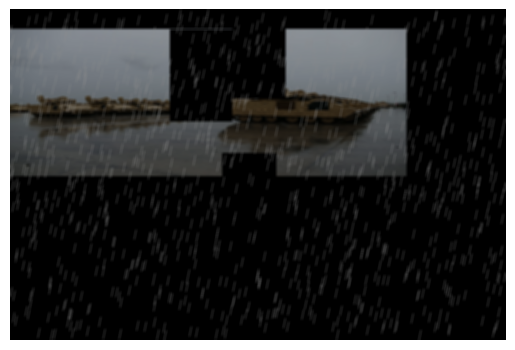

In [1]:
from pathlib import Path
from adomvi.datasets.augmentation import show_image, func_augmentation, yolo_to_voc, load_labels, apply_augmentation
import cv2


# Exemple d'utilisation pour une image
image_path = Path() / 'dataset/images/test/00e28b8687851c45.jpg'
label_path = Path() / 'dataset/labels/test/00e28b8687851c45.txt'

aug_image, aug_bboxes = apply_augmentation(image_path, label_path, func_augmentation)


show_image(aug_image, aug_bboxes)


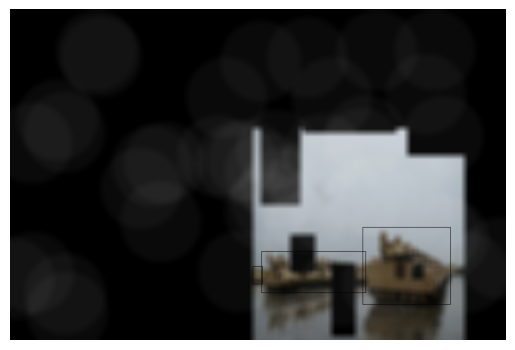

In [2]:
from adomvi.datasets.augmentation import show_image, func_augmentation, yolo_to_voc, load_labels
import cv2


# Charger l'image et les labels
image = cv2.imread(image_path)
bboxes = load_labels(label_path)
voc_bboxes = yolo_to_voc(image.shape, bboxes)

# Appliquer l'augmentation
aug_image, aug_bboxes = func_augmentation(image, voc_bboxes)

# Afficher l'image avec les boîtes englobantes
show_image(aug_image, aug_bboxes)